In [24]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pickle
from tqdm import trange
try:
  from helpers import get_model_size, estimate_loss, normalize_tensor
except ModuleNotFoundError:
  import sys
  sys.path.append("../")
  from helpers import get_model_size, estimate_loss, normalize_tensor

torch.manual_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# we actually just need it to download cifar dataset
# torchvision.datasets.CIFAR10(train=True, download=True, root='../data/', transform=transforms.ToTensor())
# torchvision.datasets.CIFAR10(train=False, download=True, root='../data/', transform=transforms.ToTensor())

In [20]:
EPOCHS = 50
BATCH_SIZE = 256
LR = 0.01
# MOMENTUM = 0.875
# WEIGH_DECAY = 0.00125

In [37]:
for x, _ in val_loader:
  r_mean = torch.mean(x[:,0, :,:].float())
  g_mean = torch.mean(x[:,1,:,:].float())
  b_mean = torch.mean(x[:,2, :,:].float())

In [47]:
r = x[:,0, :,:]
g = x[:,1, :,:]
b = x[:,2, :,:]


In [53]:
r_mean = torch.mean(x[:,0, :,:].float())
g_mean = torch.mean(x[:,1,:,:].float())
b_mean = torch.mean(x[:,2, :,:].float())

In [45]:
means = torch.mean(x.float(), dim=[2,3])

In [39]:
r = x[:,0,:,:].mean()

In [40]:
r

torch.Size([256, 32, 32])

In [ ]:
# I need to find the mean and std of the dataset to apply a valid normalization

def calculate_mean_std(loader):
  mean_r, mean_g, mean_b = 0
  std_r, std_g, std_b = 0
  cntr = 0
  for x, _ in loader:
    

In [29]:
class CiFaData(Dataset):
  def __init__(self, stage="train", transform=None, device="cpu"):
    # self.device = device
    self.base_folder = "cifar-10-batches-py"
    self.transform = transform
    if stage == "train":
      batch_collection = [f"data_batch_{i}" for i in range(1, 5)]
    elif stage == "val":
      batch_collection = ["data_batch_5"]
    elif stage == "test":
      batch_collection = ["test_batch"]
    else:
      raise ValueError("Invalid stage, choose from train, val, test.")
    self.x_data = []
    self.y_data = []
    for batch in batch_collection:
      with open(f"../data/cifar-10-batches-py/{batch}", "rb") as f:
        data = pickle.load(f, encoding="latin1") 
        self.x_data.extend(data["data"])
        self.y_data.extend(data["labels"])
    self.y_data = torch.tensor(self.y_data)
    # self.x_data = normalize_tensor(torch.tensor(np.vstack(self.x_data).reshape(-1, 3, 32, 32))) # from list to vstack; results in (N, 3, 32, 32)
    self.x_data = torch.tensor(np.vstack(self.x_data).reshape(-1, 3, 32, 32))
  def __len__(self):
    return self.y_data.shape[0]
  def __getitem__(self, idx):
    if self.transform:
      return self.transform(self.x_data[idx]), self.y_data[idx]
    return self.x_data[idx], self.y_data[idx]

In [30]:
tf = transforms.Compose([transforms.RandomResizedCrop((32,32)), 
                         transforms.RandomHorizontalFlip(p=0.58)]) 
                        #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_ds = CiFaData(stage="train", device=device, transform=tf)
val_ds = CiFaData(stage="val", device=device)
test_ds = CiFaData(stage="test", device=device)

# pinning memory, takes cpu data and pins it to the gpu.
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=14, pin_memory=True) 
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=14, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=14, pin_memory=True)

ResNet 18

In [6]:
# from the paper: 
# We adopt batch normalization (BN) [16] right after each convolution and
# before activation, following [16].

In [27]:
class PrepBlock(nn.Module):
  # fixed channels for cifar
  def __init__(self):
    super().__init__()
    self.prep_block = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )
  def forward(self, x):
    return self.prep_block(x)
  def init_weights(self):
    for layer in self.prep_block:
      if isinstance(layer, nn.Conv2d):
        nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
        if layer.bias is not None:
          layer.bias.data.zero_()

class ComputeBlock(nn.Module):
  def __init__(self, inchannels, outchannels, stride, downsample=None):
    super().__init__()
    self.convblock = nn.Sequential(
      nn.Conv2d(in_channels=inchannels, out_channels=outchannels, kernel_size=3, padding=1, stride=stride, bias=False),
      nn.BatchNorm2d(outchannels),
      nn.ReLU(),
      nn.Conv2d(in_channels=outchannels, out_channels=outchannels, kernel_size=3, padding=1, stride=1, bias=False),
      nn.BatchNorm2d(outchannels)
    )
    self.downsample = downsample
    if not inchannels == outchannels:
      self.downsample = nn.Sequential(
        nn.Conv2d(in_channels=inchannels, out_channels=outchannels, kernel_size=1, stride=2, bias=False),
        nn.BatchNorm2d(outchannels)
      )
    self.relu = nn.ReLU()
  def forward(self, x):
    x_skip = x 
    x = self.convblock(x)
    if self.downsample:
      x_skip = self.downsample(x_skip)
    out = self.relu(x+x_skip)
    return out
  def init_weights(self):
    for layer in self.convblock:
      if isinstance(layer, nn.Conv2d):
        nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
        if layer.bias is not None:
          layer.bias.data.zero_()
    if self.downsample:
      for layer in self.downsample:
        if isinstance(layer, nn.Conv2d):
          nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
          if layer.bias is not None:
            layer.bias.data.zero_()
  
  
class ResNet18New(nn.Module):
  def __init__(self):
    super().__init__()
    self.resnet = nn.Sequential(
      PrepBlock(),
      ComputeBlock(64, 64, stride=1),
      ComputeBlock(64,128, stride=2),
      ComputeBlock(128,256, stride=2),
      ComputeBlock(256, 512, stride=2),
      nn.AdaptiveAvgPool2d((1,1)),
      nn.Flatten(start_dim=1),
      nn.Linear(512, 10)
    )
  def forward(self, x):
    return self.resnet(x)
  def init_weights(self):
    for module in self.modules():
      if isinstance(module, ComputeBlock):
        module.init_weights()
      elif isinstance(module, PrepBlock):
        module.init_weights()
      elif isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')

model size: 18.756 MB


epoch 100 | training loss: 1.0395 | validation loss: 0.9779 | current lr: 0.010000: 100%|██████████| 100/100 [02:55<00:00,  1.76s/it]


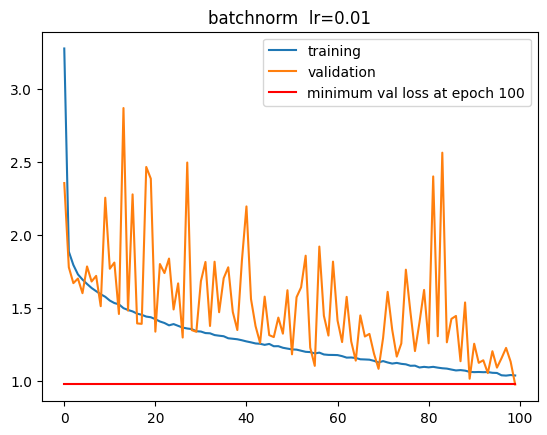

In [28]:
model = ResNet18New()
model.init_weights()
model.to(device)

# optimizer = optim.AdamW(params=[p for p in model.parameters() if p.requires_grad==True], lr=lr)
optimizer = optim.SGD(params=model.parameters(), lr=LR) #, weight_decay=WEIGH_DECAY, momentum=MOMENTUM)
scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss()

model_size = get_model_size(model)

# training loop
losses = []
raw_losses = []
val_losses = []

for i in (t:=trange(EPOCHS)):
  model.train()
  epoch_loss = []
  for step, (x, y) in enumerate(train_loader):
    x = x.to(device)
    y = y.to(device)
    predictions = model(x)
    loss = criterion(predictions, y)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    raw_losses.append(loss.item())
    epoch_loss.append(loss.item())

  # only one per iteration
  losses.append(np.mean(epoch_loss))
  val_loss, val_acc = estimate_loss(model, val_loader, criterion, device)
  val_losses.append(val_loss)
  # scheduler.step()
  t.set_description(f"epoch {i+1} | training loss: {losses[-1]:.4f} | validation loss: {val_losses[-1]:.4f} | current lr: {optimizer.param_groups[0]['lr']:.6f}")
  
# test_loss = estimate_loss(model, test_loader, criterion, device) 
# print(f'test loss : {test_loss}')


plt.figure()
plt.title(f'batchnorm  lr={LR}')
plt.plot(range(EPOCHS), losses, label='training')
plt.plot(range(EPOCHS), val_losses, label='validation')
plt.plot(range(EPOCHS), [np.min(val_losses)]*EPOCHS, color='r', label=f'minimum val loss at epoch {np.argmin(val_losses)+1}')
# plt.plot(range(EPOCHS), [test_loss]*EPOCHS, linestyle='dashed', label='test loss')
plt.legend()
plt.show()

In [ ]:
model

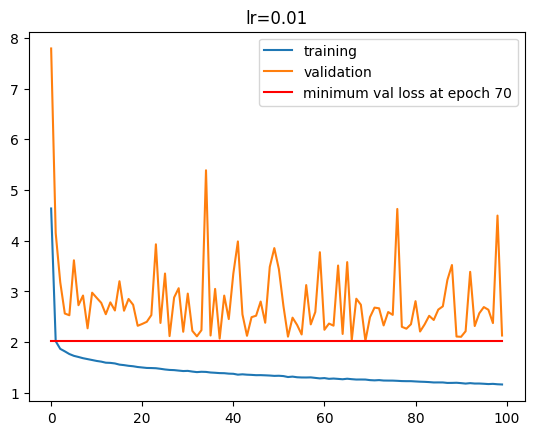

In [17]:
plt.figure()
plt.title(f'lr={LR}')
plt.plot(range(EPOCHS), losses, label='training')
plt.plot(range(EPOCHS), val_losses, label='validation')
plt.plot(range(EPOCHS), [np.min(val_losses)]*EPOCHS, color='r', label=f'minimum val loss at epoch {np.argmin(val_losses)+1}')
# plt.plot(range(EPOCHS), [test_loss]*EPOCHS, linestyle='dashed', label='test loss')
plt.legend()
plt.show()

In [58]:
# inspect the graph
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("torchlogs/")
writer.add_graph(model, x)
writer.close()

In [16]:
with open('../data/cifar-10-batches-py/batches.meta', 'rb') as f:
  meta = pickle.load(f)
meta['label_names']

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [59]:
incorrect_preds = []
test_loss = []
model.eval()
n_correct = 0
n_total = 0
with torch.no_grad():
  for x, y in test_loader:
    x = x.to(device)
    pred = model(x)
    loss = criterion(pred.to(device), y.to(device))
    test_loss.append(loss.item()) 
    logits = F.softmax(pred.to('cpu'), dim=1).argmax(dim=1)
    n_total += pred.shape[0]
    n_correct += (y == logits).sum().numpy()
    # extract images ??
print(f'accuracy: {n_correct/n_total}')

accuracy: 0.3251


In [18]:
estimate_loss(model, test_loader, criterion, 'cuda')

1.1917829168319702

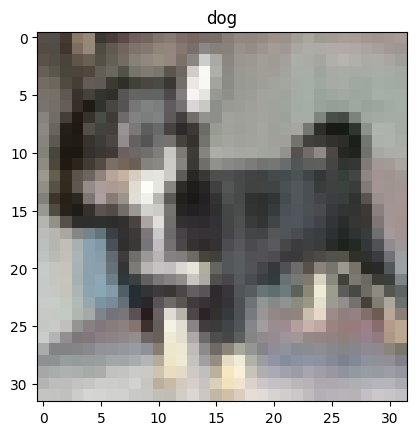

In [55]:
n = 9
input_ = x[n].cpu().permute(1,2,0).numpy()

plt.title(meta['label_names'][y[n]])
plt.imshow(input_)

# todos:
## add a good scheduler
## check if batchnorm is properly applied - probably yes
## hyperparameter tuning
## extract feature detection layers
## increase size: make a resnet 50
### add bottlenecks

# visualize feature maps

we can loop over the elements with model.children() or just address individual layers like:
model.block0[n]; you can go down until you hit a 'Sequential' block and then go on slicing


seems like a good guide: 
https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573

In [113]:
res18.block4.block[1].block[0]

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [114]:
weights = res18.block4.block[1].block[0].weight.detach().clone()
print(weights.shape)
weights = normalize_tensor(weights)
filter_img = torchvision.utils.make_grid(weights, nrow=int(np.sqrt(weights.shape[0])))
plt.imshow(filter_img.permute(1,2,0))

torch.Size([512, 512, 3, 3])


TypeError: Invalid shape (122, 112, 512) for image data

In [75]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

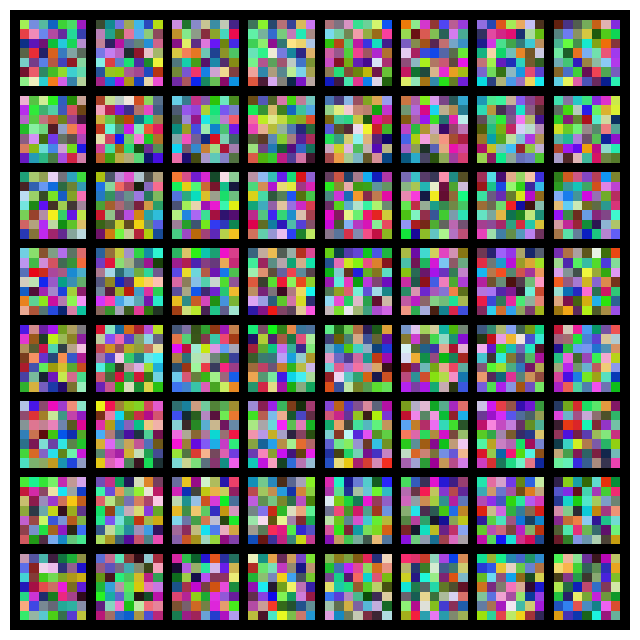

In [84]:
layer = res18.block0[0].weight.detach().clone()
visTensor(layer)
plt.axis('off')
plt.ioff()
plt.show()

In [103]:
res18.block1.block[0]


SubBlock(
  (block): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [92]:
# first_block = res18.block0[0].weight.detach().clone()
first_block = res18.block1.block[0].weight.detach.clone()
print(first_block.shape)
first_block =normalize_tensor(first_block)
filter_img = torchvision.utils.make_grid(first_block, nrow=int(np.sqrt(first_block.shape[0])))
plt.axis('off')
plt.ioff()
plt.imshow(filter_img.permute(1,2,0))
plt.show()

AttributeError: 'SubBlock' object has no attribute 'weight'

In [21]:
weights = []
conv_layers = []

model_children = list(res18.children())

cnt = 0

for i in range(len(model_children)):
  # this only counts the shape shifter-convs! - need to go into the sub blocks
  if type(model_children[i]) == nn.Conv2d:
    cnt +=1

print(cnt)

3
